<a href="https://colab.research.google.com/github/Rominaarab/Machine-learning/blob/main/Thesis_pieline_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from __future__ import annotations
import os
import sys
import math
import json
import random
from dataclasses import dataclass, asdict
from typing import Dict, List, Optional, Tuple
import warnings
warnings.filterwarnings('ignore')

# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pickle
from pathlib import Path

# Deep learning
try:
    import torch
    import torch.nn as nn
    import torch.nn.functional as F
    from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
    from torch.nn import TransformerEncoder, TransformerEncoderLayer
    TORCH_AVAILABLE = True
except Exception:
    TORCH_AVAILABLE = False

# Machine learning
try:
    from sklearn.metrics import (
        roc_auc_score, average_precision_score, f1_score, matthews_corrcoef,
        brier_score_loss, roc_curve, precision_recall_curve
    )
    from sklearn.model_selection import train_test_split, StratifiedKFold
    from sklearn.impute import KNNImputer, IterativeImputer
    from sklearn.preprocessing import StandardScaler, RobustScaler
    from sklearn.metrics import (roc_auc_score, average_precision_score, f1_score,
                           matthews_corrcoef, confusion_matrix, classification_report)
    from sklearn.ensemble import RandomForestClassifier
    SKLEARN_AVAILABLE = True
except Exception:
    SKLEARN_AVAILABLE = False

# Bioinformatics
try:
    import rpy2.robjects as robjects
    from rpy2.robjects import pandas2ri, R, StrVector, ListVector
    from rpy2.robjects.packages import importr
    RPY2_AVAILABLE = True
except Exception:
    RPY2_AVAILABLE = False

# Interpretability
import shap

# AWS Integration
try:
    !pip install boto3 sagemaker
    import boto3
    import sagemaker
except Exception:
    AWS_AVAILABLE = False

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [ ]:
# Set random seeds for reproducibility
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

In [ ]:
print("Environment setup complete!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

Environment setup complete!
PyTorch version: 2.8.0+cu126
CUDA available: True
CUDA device: Tesla T4


In [ ]:
class ModelConfig:
    """Centralized configuration for the CMO-Transformer model"""

    def __init__(self):
        # Model architecture parameters
        self.hidden_dim = 128
        self.num_heads = 8
        self.num_layers = 6
        self.dropout_rate = 0.1
        self.num_classes = 2  # binary classification (responder vs resistant)


        # Data dimensions (will be updated based on actual data)
        self.m6a_genes = 15
        self.lncrna_genes = 6
        self.mirna_genes = 6
        self.circrna_genes = 4
        self.metabolic_pathways = 4
        self.immune_genes = 10

        # Training parameters
        self.device = device
        self.batch_size = 32
        self.learning_rate = 1e-4
        self.weight_decay = 1e-5
        self.max_epochs = 100
        self.patience = 15

        # Data paths
        self.data_dir = Path("data")
        self.results_dir = Path("results")
        self.models_dir = Path("models")

        # Create directories
        for directory in [self.data_dir, self.results_dir, self.models_dir]:
            directory.mkdir(exist_ok=True)

        # AWS configuration (for deployment)
        self.aws_region = "eu-central-1"  # Frankfurt for Berlin-based research
        self.s3_bucket = "cmo-transformer-nsclc-data"

        # Reproducibility
        self.random_seed = RANDOM_SEED

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Initialize configuration
config = ModelConfig()
print(f"Configuration initialized with data directory: {config.data_dir}")

Configuration initialized with data directory: data


In [ ]:
class SyntheticDataGenerator:
    """Generate realistic synthetic omics data for demonstration"""

    def __init__(self, config, n_samples=500):
        self.config = config
        self.n_samples = n_samples
        np.random.seed(config.random_seed)

    def generate_m6a_data(self):
        """Generate m6A regulator expression data"""
        m6a_genes = [
            'METTL3', 'METTL14', 'FTO', 'ALKBH5', 'WTAP',
            'YTHDC1', 'YTHDC2', 'YTHDF1', 'YTHDF2', 'IGF2BP1',
            'IGF2BP2', 'HNRNPC', 'RBM15', 'ZC3H13', 'IGF2BP3'
        ]

        # Create correlated expression data
        mean_expression = np.random.normal(5, 1, len(m6a_genes))
        cov_matrix = np.eye(len(m6a_genes)) * 0.5 + np.ones((len(m6a_genes), len(m6a_genes))) * 0.1

        data = np.random.multivariate_normal(mean_expression, cov_matrix, self.n_samples)

        return pd.DataFrame(data, columns=m6a_genes)

    def generate_ncrna_data(self):
        """Generate non-coding RNA expression data"""
        lncrnas = ['HOTAIR', 'MALAT1', 'NEAT1', 'LINC00460', 'XIST', 'H19']
        mirnas = ['miR-34a', 'miR-146b-5p', 'miR-326', 'miR-149', 'miR-155', 'miR-21']
        circrnas = ['circ_001678', 'circ_0003222', 'circIGF2BP3', 'circSCN8A']

        ncrna_data = {}

        # Generate each ncRNA type with different expression patterns
        for ncrna_type, genes in [('lncrna', lncrnas), ('mirna', mirnas), ('circrna', circrnas)]:
            mean_expr = np.random.normal(3, 0.5, len(genes))
            cov = np.eye(len(genes)) * 0.3 + np.random.random((len(genes), len(genes))) * 0.1

            data = np.random.multivariate_normal(mean_expr, cov, self.n_samples)
            ncrna_data[ncrna_type] = pd.DataFrame(data, columns=genes)

        return ncrna_data

    def generate_metabolic_data(self):
        """Generate metabolic pathway activity scores (GSVA-like)"""
        pathways = ['Glycolysis', 'Arginine_Metabolism', 'Tryptophan_Kynurenine', 'Glutaminolysis']

        # Pathway activities are correlated and sum to zero (GSVA property)
        base_activities = np.random.normal(0, 0.5, (self.n_samples, len(pathways)))

        # Normalize to have zero mean across pathways for each sample
        normalized_activities = base_activities - base_activities.mean(axis=1, keepdims=True)

        return pd.DataFrame(normalized_activities, columns=pathways)

    def generate_immune_data(self):
        """Generate immune checkpoint gene expression"""
        immune_genes = [
            'CD274',  # PD-L1
            'PDCD1',  # PD-1
            'CTLA4', 'LAG3', 'TIGIT', 'HAVCR2', 'VSIR', 'BTLA', 'CD276', 'ICOS'
        ]

        # Immune genes often upregulated together in resistant tumors
        mean_expr = np.random.normal(4, 1, len(immune_genes))
        cov = np.eye(len(immune_genes)) * 0.4 + np.ones((len(immune_genes), len(immune_genes))) * 0.2

        data = np.random.multivariate_normal(mean_expr, cov, self.n_samples)

        return pd.DataFrame(data, columns=immune_genes)

    def generate_clinical_labels(self, processed_data):
        """Generate realistic clinical response labels based on molecular data"""

        # Extract key features for label generation
        m6a_data = processed_data['m6a']
        metabolic_data = processed_data['metabolic']
        immune_data = processed_data['immune']

        # Create realistic response patterns
        # Higher METTL3 -> resistance, Higher ALKBH5 -> response
        # Higher glycolysis -> resistance, Higher PD-L1 -> resistance

        resistance_score = (
            m6a_data['METTL3'] * 0.3 +
            metabolic_data['Glycolysis'] * 0.2 +
            immune_data['CD274'] * 0.2 +
            -m6a_data['ALKBH5'] * 0.2 +
            np.random.normal(0, 0.5, self.n_samples)
        )

        # Convert to binary response (0 = non-responder, 1 = responder)
        # Create imbalanced dataset (20% responders, realistic for immunotherapy)
        threshold = np.percentile(resistance_score, 80)
        binary_response = (resistance_score < threshold).astype(int)

        # Create clinical dataframe
        clinical_data = pd.DataFrame({
            'patient_id': [f'PATIENT_{i:03d}' for i in range(self.n_samples)],
            'binary_response': binary_response,
            'resistance_score': resistance_score,
            'age': np.random.normal(65, 10, self.n_samples),
            'sex': np.random.choice(['M', 'F'], self.n_samples),
            'smoking_status': np.random.choice(['Never', 'Former', 'Current'], self.n_samples, p=[0.2, 0.5, 0.3]),
            'stage': np.random.choice(['IIIA', 'IIIB', 'IV'], self.n_samples, p=[0.2, 0.3, 0.5])
        })

        return clinical_data

    def generate_complete_dataset(self):
        """Generate complete synthetic multiomics dataset"""
        print("Generating synthetic multiomics data...")

        # Generate molecular data
        m6a_data = self.generate_m6a_data()
        ncrna_data = self.generate_ncrna_data()
        metabolic_data = self.generate_metabolic_data()
        immune_data = self.generate_immune_data()

        # Combine all molecular data
        processed_data = {
            'm6a': m6a_data,
            'lncrna': ncrna_data['lncrna'],
            'mirna': ncrna_data['mirna'],
            'circrna': ncrna_data['circrna'],
            'metabolic': metabolic_data,
            'immune': immune_data
        }

        # Generate clinical labels
        clinical_data = self.generate_clinical_labels(processed_data)

        print(f"Generated data for {self.n_samples} samples")
        print(f"Response rate: {clinical_data['binary_response'].mean():.1%}")

        return processed_data, clinical_data

In [ ]:
# Generate synthetic data
data_generator = SyntheticDataGenerator(config, n_samples=500)
processed_data, clinical_data = data_generator.generate_complete_dataset()

Generating synthetic multiomics data...
Generated data for 500 samples
Response rate: 80.0%


In [ ]:
# Update config with actual data dimensions
config.m6a_genes = processed_data['m6a'].shape[1]
config.lncrna_genes = processed_data['lncrna'].shape[1]
config.mirna_genes = processed_data['mirna'].shape[1]
config.circrna_genes = processed_data['circrna'].shape[1]
config.metabolic_pathways = processed_data['metabolic'].shape[1]
config.immune_genes = processed_data['immune'].shape[1]

In [ ]:
print("Data dimensions:")
for modality, data in processed_data.items():
    print(f"  {modality}: {data.shape}")

Data dimensions:
  m6a: (500, 15)
  lncrna: (500, 6)
  mirna: (500, 6)
  circrna: (500, 4)
  metabolic: (500, 4)
  immune: (500, 10)


In [ ]:
def create_eda_dashboard(processed_data, clinical_data):
    """Create exploratory data analysis dashboard"""

    fig, axes = plt.subplots(3, 3, figsize=(18, 15))
    fig.suptitle('Exploratory Data Analysis Dashboard', fontsize=16, y=0.98)

    # 1. Response distribution
    response_counts = clinical_data['binary_response'].value_counts()
    axes[0, 0].pie(response_counts.values, labels=['Non-responder', 'Responder'],
                   autopct='%1.1f%%', colors=['red', 'green'])
    axes[0, 0].set_title('Response Distribution')

    # 2. Age distribution by response
    for response, label, color in [(0, 'Non-responder', 'red'), (1, 'Responder', 'green')]:
        subset = clinical_data[clinical_data['binary_response'] == response]
        axes[0, 1].hist(subset['age'], alpha=0.7, label=label, color=color, bins=20)
    axes[0, 1].set_xlabel('Age')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].set_title('Age Distribution by Response')
    axes[0, 1].legend()

    # 3. Sex distribution by response
    sex_response = pd.crosstab(clinical_data['sex'], clinical_data['binary_response'])
    sex_response.plot(kind='bar', ax=axes[0, 2], color=['red', 'green'])
    axes[0, 2].set_title('Sex Distribution by Response')
    axes[0, 2].set_xlabel('Sex')
    axes[0, 2].tick_params(axis='x', rotation=0)

    # 4. m6A gene expression heatmap
    m6a_subset = processed_data['m6a'].iloc[:50, :10]  # First 50 samples, 10 genes
    sns.heatmap(m6a_subset.T, cmap='RdBu_r', center=0, ax=axes[1, 0], cbar=True)
    axes[1, 0].set_title('m6A Gene Expression (Sample)')
    axes[1, 0].set_xlabel('Samples')
    axes[1, 0].set_ylabel('Genes')

    # 5. Metabolic pathway activities
    pathway_means_by_response = []
    for response in [0, 1]:
        subset = processed_data['metabolic'][clinical_data['binary_response'] == response]
        pathway_means_by_response.append(subset.mean())

    pathway_comparison = pd.DataFrame(pathway_means_by_response,
                                    index=['Non-responder', 'Responder']).T
    pathway_comparison.plot(kind='bar', ax=axes[1, 1], color=['red', 'green'])
    axes[1, 1].set_title('Metabolic Pathway Activity by Response')
    axes[1, 1].set_ylabel('Mean Activity Score')
    axes[1, 1].tick_params(axis='x', rotation=45)

    # 6. Immune gene expression comparison
    immune_key_genes = ['CD274', 'PDCD1', 'CTLA4', 'LAG3']
    immune_subset = processed_data['immune'][immune_key_genes]

    immune_means_by_response = []
    for response in [0, 1]:
        subset = immune_subset[clinical_data['binary_response'] == response]
        immune_means_by_response.append(subset.mean())

    immune_comparison = pd.DataFrame(immune_means_by_response,
                                   index=['Non-responder', 'Responder']).T
    immune_comparison.plot(kind='bar', ax=axes[1, 2], color=['red', 'green'])
    axes[1, 2].set_title('Key Immune Genes by Response')
    axes[1, 2].set_ylabel('Mean Expression')
    axes[1, 2].tick_params(axis='x', rotation=45)

    # 7. Correlation heatmap (sample of features)
    # Combine key features from each modality
    key_features = pd.concat([
        processed_data['m6a'][['METTL3', 'ALKBH5', 'YTHDF1']],
        processed_data['metabolic'],
        processed_data['immune'][['CD274', 'CTLA4']]
    ], axis=1)

    corr_matrix = key_features.corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, ax=axes[2, 0])
    axes[2, 0].set_title('Feature Correlation Matrix')

    # 8. ncRNA expression distributions
    ncrna_data = pd.concat([
        processed_data['lncrna'][['HOTAIR', 'MALAT1']],
        processed_data['mirna'][['miR-34a', 'miR-155']]
    ], axis=1)

    ncrna_data.boxplot(ax=axes[2, 1])
    axes[2, 1].set_title('ncRNA Expression Distributions')
    axes[2, 1].tick_params(axis='x', rotation=45)

    # 9. Principal Component Analysis visualization
    from sklearn.decomposition import PCA

    # Combine all features for PCA
    all_features = pd.concat(list(processed_data.values()), axis=1)

    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(all_features)

    colors = ['red', 'green']
    labels = ['Non-responder', 'Responder']

    for response in [0, 1]:
        mask = clinical_data['binary_response'] == response
        axes[2, 2].scatter(pca_result[mask, 0], pca_result[mask, 1],
                          c=colors[response], alpha=0.6, label=labels[response])

    axes[2, 2].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
    axes[2, 2].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
    axes[2, 2].set_title('PCA of All Features')
    axes[2, 2].legend()

    plt.tight_layout()
    plt.savefig(config.results_dir / 'eda_dashboard.png', dpi=300, bbox_inches='tight')
    plt.show()

    return fig

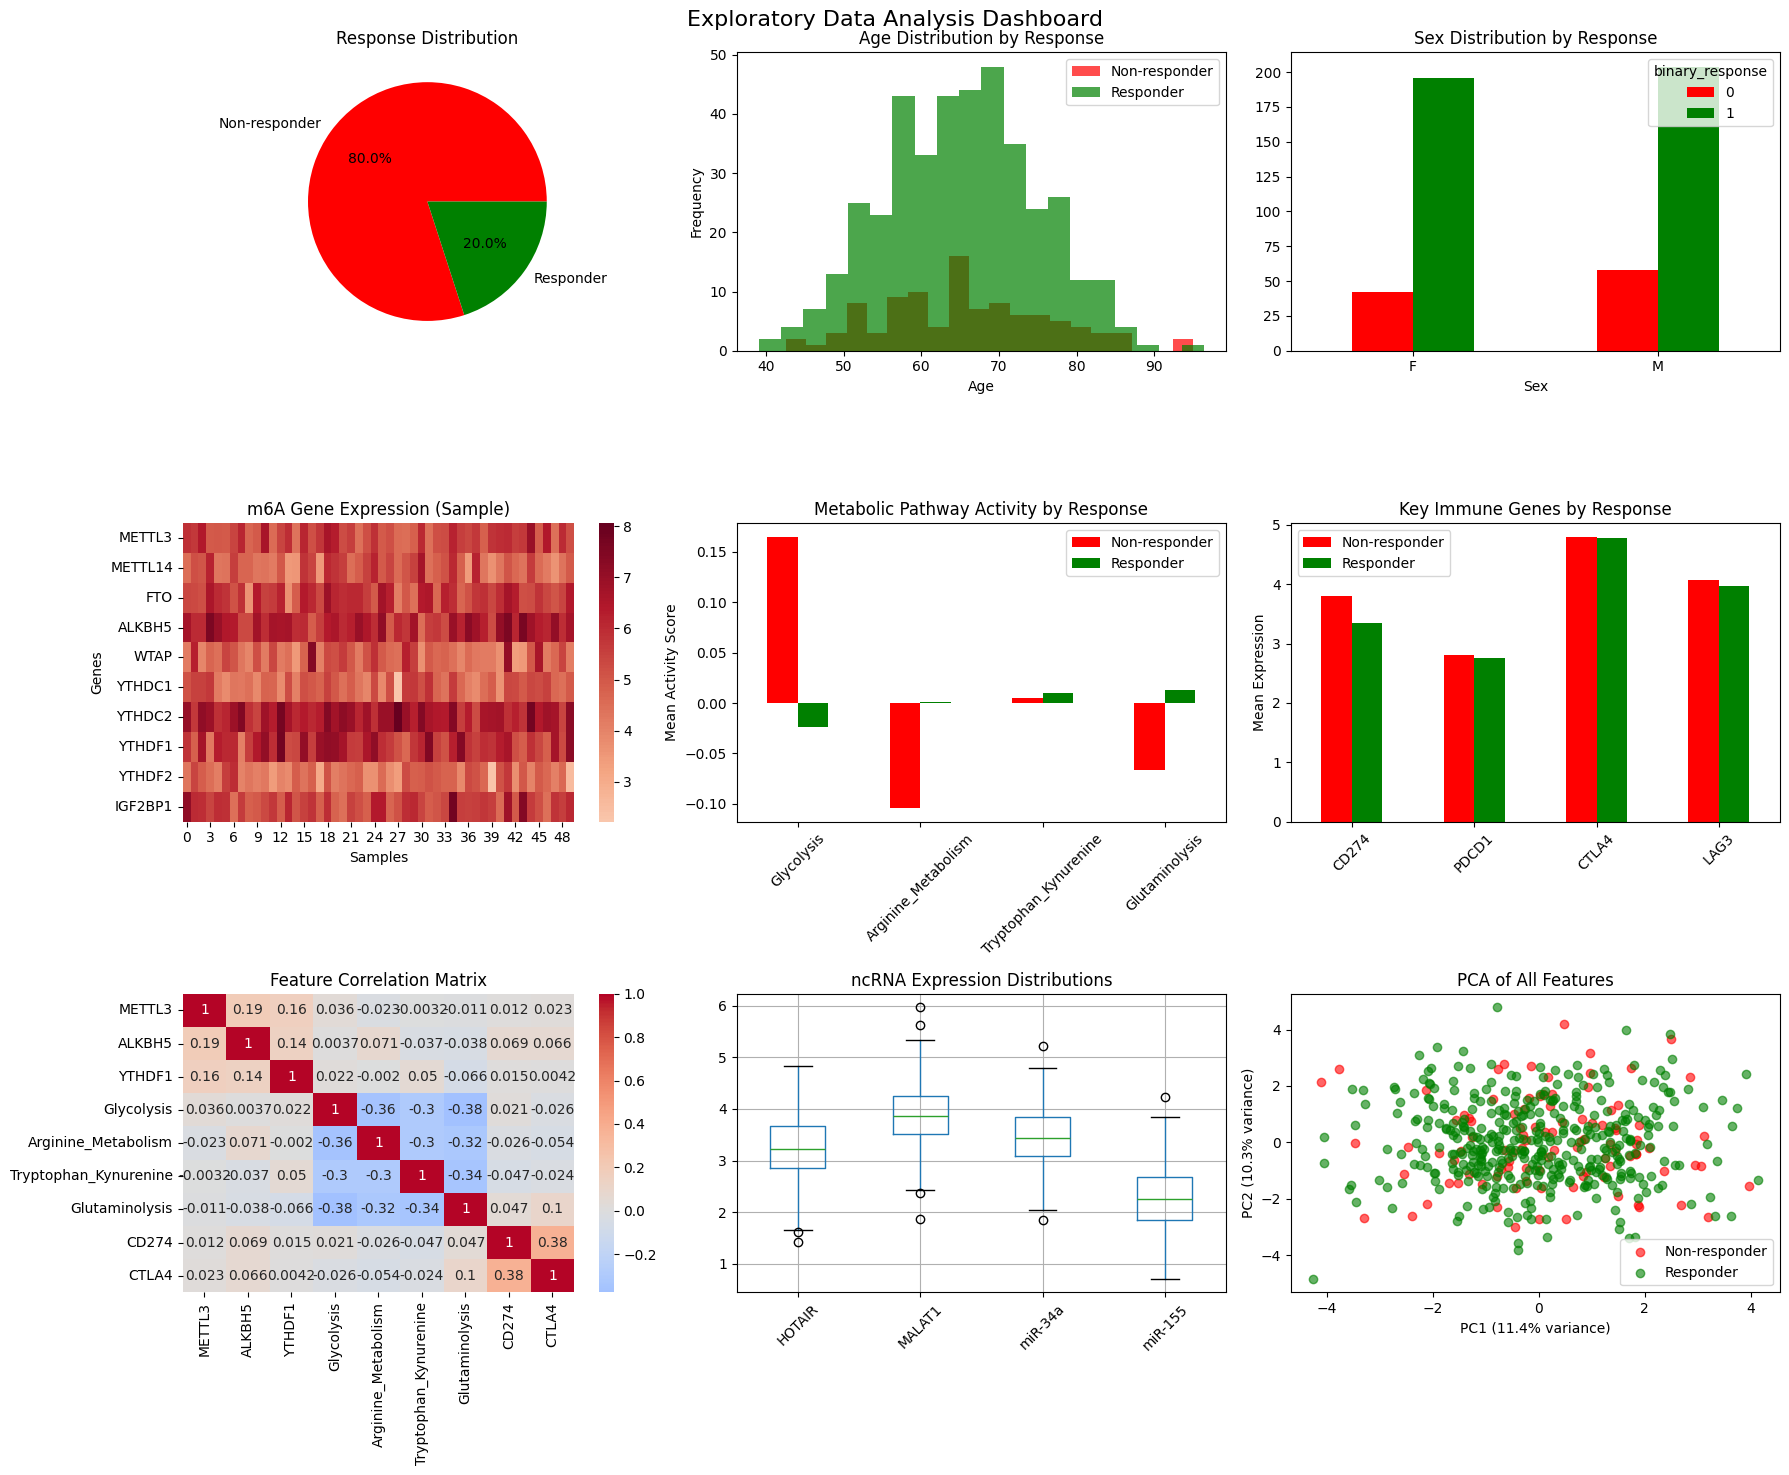

Exploratory data analysis complete!


In [ ]:
# Create EDA dashboard
eda_fig = create_eda_dashboard(processed_data, clinical_data)
print("Exploratory data analysis complete!")

In [ ]:
class PositionalEncoding(nn.Module):
    """Positional encoding for transformer layers"""

    def __init__(self, d_model, max_len=1000):
        super().__init__()
        self.dropout = nn.Dropout(p=0.1)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)

        div_term = torch.exp(torch.arange(0, d_model, 2).float() *
                            (-np.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)

        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [ ]:
class PositionalEncoding(nn.Module):
    """Positional encoding for transformer layers"""

    def __init__(self, d_model, max_len=1000):
        super().__init__()
        self.dropout = nn.Dropout(p=0.1)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)

        div_term = torch.exp(torch.arange(0, d_model, 2).float() *
                            (-np.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)

        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [ ]:
class MLPEncoder(nn.Module):
    def __init__(self, in_dim, hidden=256, emb=128, dropout=0.2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, emb),
            nn.ReLU()
        )
    def forward(self, x):  # [B, in_dim]
        return self.net(x)  # [B, emb]

In [ ]:
class CrossModalBlock(nn.Module):
    def __init__(self, emb_dim, heads=4, dropout=0.1):
        super().__init__()
        self.attn = nn.MultiheadAttention(emb_dim, heads, dropout=dropout, batch_first=True)
        self.norm1 = nn.LayerNorm(emb_dim)
        self.ff = nn.Sequential(
            nn.Linear(emb_dim, emb_dim*4),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(emb_dim*4, emb_dim),
        )
        self.norm2 = nn.LayerNorm(emb_dim)

    def forward(self, x, need_weights: bool = False):
        # x: [B, T(modalities), D]
        attn_out, attn_w = self.attn(x, x, x, need_weights=need_weights, average_attn_weights=False)
        x = self.norm1(x + attn_out)
        y = self.ff(x)
        x = self.norm2(x + y)
        return x, attn_w if need_weights else None


In [ ]:
class CMOTransformer(nn.Module):
    """
    Cross-Modal Omics Transformer (your main deep model).
    Supply modality_input_dims such as {'rna': 1000, 'atac': 500, 'clinical': 32}.
    """
    def __init__(self, modality_input_dims: Dict[str, int], hidden=256, emb=128,
                 heads=4, num_layers=2, num_classes=2, dropout=0.2):
        super().__init__()
        self.modalities = list(modality_input_dims.keys())
        self.encoders = nn.ModuleDict({
            m: MLPEncoder(modality_input_dims[m], hidden, emb, dropout) for m in self.modalities
        })
        self.blocks = nn.ModuleList([CrossModalBlock(emb, heads, dropout) for _ in range(num_layers)])
        self.classifier = nn.Sequential(
            nn.Linear(emb * len(self.modalities), hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, num_classes)
        )

    def forward(self, batch: Dict[str, torch.Tensor], return_attention: bool = False):
        # Encode each modality → tokens
        toks = []
        for m in self.modalities:
            if m not in batch:
                raise KeyError(f"Expected modality '{m}' in batch, got keys {list(batch.keys())}")
            toks.append(self.encoders[m](batch[m]))  # [B, emb]
        x = torch.stack(toks, dim=1)  # [B, T, emb]

        attn_weights_all = [] if return_attention else None
        for blk in self.blocks:
            x, attn_w = blk(x, need_weights=return_attention)
            if return_attention:
                attn_weights_all.append(attn_w)  # each: [B, heads, T, T]

        fused = x.reshape(x.size(0), -1)  # [B, T*emb]
        logits = self.classifier(fused)

        if return_attention:
            # causal_matrix is not applicable here → None
            return logits, attn_weights_all, None
        return logits


In [ ]:
class GeneformerLite(nn.Module):
    def __init__(self, num_genes: int, d_model=128, nhead=4, depth=4, num_classes=2, dropout=0.1):
        super().__init__()
        self.gene_embed = nn.Embedding(num_genes, d_model)  # token per gene
        self.pos = nn.Parameter(torch.zeros(1, num_genes, d_model))  # simple learnable positions
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead,
                                                   dim_feedforward=d_model*4, dropout=dropout,
                                                   batch_first=True, activation='gelu')
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=depth)
        self.norm = nn.LayerNorm(d_model)
        self.head = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, num_classes)
        )

    def forward(self, batch: Dict[str, torch.Tensor], return_attention: bool = False):
        # Expect batch['rna']: [B, G] (float expression)
        x = batch['rna']  # [B, G]
        B, G = x.shape
        idx = torch.arange(G, device=x.device).unsqueeze(0).expand(B, G)  # [B, G]
        tok = self.gene_embed(idx)  # [B, G, D]
        tok = tok * x.unsqueeze(-1)  # scale embeddings by expression
        tok = tok + self.pos[:, :G, :]
        z = self.encoder(tok)  # [B, G, D]
        z = self.norm(z)
        # simple pooling (CLS-less): mean pool
        pooled = z.mean(dim=1)  # [B, D]
        logits = self.head(pooled)
        if return_attention:
            # vanilla nn.TransformerEncoder doesn't expose attn weights; return None
            return logits, None, None
        return logits

In [ ]:
class ScBERTMini(nn.Module):
    def __init__(self, num_genes: int, d_model=256, nhead=8, depth=6, num_classes=2, dropout=0.1):
        super().__init__()
        self.gene_embed = nn.Embedding(num_genes, d_model)
        self.cls = nn.Parameter(torch.zeros(1, 1, d_model))  # learnable [CLS]
        self.pos = nn.Parameter(torch.zeros(1, num_genes+1, d_model))
        enc_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead,
                                               dim_feedforward=d_model*4, dropout=dropout,
                                               batch_first=True, activation='gelu', norm_first=True)
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=depth)
        self.norm = nn.LayerNorm(d_model)
        self.head = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, num_classes)
        )

    def forward(self, batch: Dict[str, torch.Tensor], return_attention: bool = False):
        x = batch['rna']  # [B, G] float
        B, G = x.shape
        idx = torch.arange(G, device=x.device).unsqueeze(0).expand(B, G)
        tok = self.gene_embed(idx) * x.unsqueeze(-1)  # [B, G, D]
        cls_tok = self.cls.expand(B, -1, -1)  # [B, 1, D]
        seq = torch.cat([cls_tok, tok], dim=1)  # [B, 1+G, D]
        seq = seq + self.pos[:, :seq.size(1), :]
        z = self.encoder(seq)  # [B, 1+G, D]
        z = self.norm(z)
        cls_out = z[:, 0]  # [CLS]
        logits = self.head(cls_out)
        if return_attention:
            return logits, None, None
        return logits


In [ ]:
class SimpleGraphConv(nn.Module):
    def __init__(self, in_dim, out_dim, bias=True):
        super().__init__()
        self.lin = nn.Linear(in_dim, out_dim, bias=bias)
    def forward(self, x, A):  # x: [B, G, C_in]; A: [G, G]
        # add self loops
        I = torch.eye(A.size(0), device=A.device, dtype=A.dtype)
        A_hat = A + I
        # degree normalization
        D_inv_sqrt = torch.diag(torch.pow(A_hat.sum(-1).clamp(min=1e-6), -0.5))
        A_norm = D_inv_sqrt @ A_hat @ D_inv_sqrt  # [G, G]
        x = torch.matmul(A_norm, x)  # [B, G, C_in]
        return self.lin(x)           # [B, G, C_out]


In [ ]:
class GNNOmics(nn.Module):
    def __init__(self, num_genes: int, A: torch.Tensor, hidden_dim=128, layers=3, num_classes=2, dropout=0.2):
        super().__init__()
        self.register_buffer('A', A)  # [G, G], stays with device
        self.proj_in = nn.Linear(1, hidden_dim)
        self.convs = nn.ModuleList([SimpleGraphConv(hidden_dim, hidden_dim) for _ in range(layers)])
        self.norms = nn.ModuleList([nn.LayerNorm(hidden_dim) for _ in range(layers)])
        self.dropout = nn.Dropout(dropout)
        self.head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_classes)
        )


    def forward(self, batch: Dict[str, torch.Tensor], return_attention: bool = False):
        x = batch['rna']  # [B, G] floats
        B, G = x.shape
        x = x.unsqueeze(-1)  # [B, G, 1]
        x = self.proj_in(x)  # [B, G, H]
        for conv, norm in zip(self.convs, self.norms):
            h = F.relu(conv(x, self.A))  # [B, G, H]
            h = norm(h)
            x = self.dropout(x + h)      # residual
        # pool across genes
        graph_emb = x.mean(dim=1)        # [B, H]
        logits = self.head(graph_emb)
        if return_attention:
            # no explicit attention maps here
            return logits, None, None
        return logits

In [ ]:
class ModalityEncoder(nn.Module):
    """Modality-specific encoder for different omics data types"""

    def __init__(self, input_dim, hidden_dim, num_layers=2, num_heads=8):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        # Input projection
        self.input_projection = nn.Linear(input_dim, hidden_dim)
        self.positional_encoding = PositionalEncoding(hidden_dim)

        # Transformer encoder
        encoder_layer = TransformerEncoderLayer(
            d_model=hidden_dim,
            nhead=num_heads,
            dim_feedforward=hidden_dim * 4,
            dropout=0.1,
            batch_first=True
        )
        self.transformer = TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Output projection
        self.output_projection = nn.Linear(hidden_dim, hidden_dim)
        self.layer_norm = nn.LayerNorm(hidden_dim)

    def forward(self, x):
        # x shape: [batch_size, num_features]
        if len(x.shape) == 2:
            x = x.unsqueeze(1)  # Add sequence dimension: [batch_size, 1, num_features]

        # Project to hidden dimension
        x = self.input_projection(x)  # [batch_size, 1, hidden_dim]

        # Apply transformer
        x = self.transformer(x)  # [batch_size, 1, hidden_dim]

        # Global pooling and projection
        x = x.squeeze(1)  # [batch_size, hidden_dim]
        x = self.output_projection(x)
        x = self.layer_norm(x)

        return x

In [ ]:
class CrossModalAttention(nn.Module):
    """Cross-modal attention mechanism for multimodal fusion"""

    def __init__(self, hidden_dim, num_heads=8, dropout=0.1):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_heads = num_heads

        self.multihead_attn = nn.MultiheadAttention(
            embed_dim=hidden_dim,
            num_heads=num_heads,
            dropout=dropout,
            batch_first=True
        )

        self.layer_norm1 = nn.LayerNorm(hidden_dim)
        self.layer_norm2 = nn.LayerNorm(hidden_dim)

        self.feed_forward = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * 4),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim * 4, hidden_dim)
        )

    def forward(self, query, key, value, return_attention=False):
        # Ensure inputs have sequence dimension
        if len(query.shape) == 2:
            query = query.unsqueeze(1)
        if len(key.shape) == 2:
            key = key.unsqueeze(1)
        if len(value.shape) == 2:
            value = value.unsqueeze(1)

        # Multi-head attention
        attn_output, attn_weights = self.multihead_attn(
            query, key, value, need_weights=return_attention
        )

        # Residual connection and layer norm
        query = self.layer_norm1(query + attn_output)

        # Feed-forward network
        ff_output = self.feed_forward(query)
        output = self.layer_norm2(query + ff_output)

        # Remove sequence dimension
        output = output.squeeze(1)

        if return_attention:
            return output, attn_weights
        else:
            return output

In [ ]:
class CausalInferenceModule(nn.Module):
    """Causal inference module for identifying molecular drivers"""

    def __init__(self, num_modalities, hidden_dim):
        super().__init__()
        self.num_modalities = num_modalities
        self.hidden_dim = hidden_dim

        # Learnable causal adjacency matrix
        self.causal_adjacency = nn.Parameter(
            torch.randn(num_modalities, num_modalities) * 0.1
        )

        # Intervention effect estimator
        self.intervention_mlp = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, modality_embeddings):
        """Compute causal effects between modalities"""
        batch_size = modality_embeddings[0].size(0)
        causal_effects = []

        # Compute pairwise causal effects
        causal_matrix = torch.sigmoid(self.causal_adjacency)

        for i, cause_embedding in enumerate(modality_embeddings):
            total_causal_effect = torch.zeros(batch_size, 1, device=cause_embedding.device)

            for j, effect_embedding in enumerate(modality_embeddings):
                if i != j:
                    # Compute intervention effect
                    combined_embedding = torch.cat([cause_embedding, effect_embedding], dim=1)
                    intervention_effect = self.intervention_mlp(combined_embedding)

                    # Weight by learned causal strength
                    causal_weight = causal_matrix[i, j]
                    weighted_effect = causal_weight * intervention_effect

                    total_causal_effect += weighted_effect

            causal_effects.append(total_causal_effect)

        return torch.cat(causal_effects, dim=1), causal_matrix

In [ ]:
class CausalMultiOmicsTransformer(nn.Module):
    """Complete multimodal transformer with causal inference"""

    def __init__(self, config):
        super().__init__()
        self.config = config

        # Modality-specific encoders
        self.m6a_encoder = ModalityEncoder(
            input_dim=config.m6a_genes,
            hidden_dim=config.hidden_dim,
            num_layers=2,
            num_heads=config.num_heads
        )

        self.lncrna_encoder = ModalityEncoder(
            input_dim=config.lncrna_genes,
            hidden_dim=config.hidden_dim,
            num_layers=2,
            num_heads=config.num_heads
        )

        self.mirna_encoder = ModalityEncoder(
            input_dim=config.mirna_genes,
            hidden_dim=config.hidden_dim,
            num_layers=2,
            num_heads=config.num_heads
        )

        self.circrna_encoder = ModalityEncoder(
            input_dim=config.circrna_genes,
            hidden_dim=config.hidden_dim,
            num_layers=2,
            num_heads=config.num_heads
        )

        self.metabolic_encoder = ModalityEncoder(
            input_dim=config.metabolic_pathways,
            hidden_dim=config.hidden_dim,
            num_layers=2,
            num_heads=config.num_heads
        )

        self.immune_encoder = ModalityEncoder(
            input_dim=config.immune_genes,
            hidden_dim=config.hidden_dim,
            num_layers=2,
            num_heads=config.num_heads
        )

        # Cross-modal attention layers
        self.cross_attention_layers = nn.ModuleList([
            CrossModalAttention(config.hidden_dim, config.num_heads, config.dropout_rate)
            for _ in range(3)  # 3 layers of cross-attention
        ])

        # Causal inference module
        self.causal_module = CausalInferenceModule(
            num_modalities=6,  # m6a, lncrna, mirna, circrna, metabolic, immune
            hidden_dim=config.hidden_dim
        )

        # Final fusion and classification
        self.fusion_layer = nn.Sequential(
            nn.Linear(config.hidden_dim * 6, config.hidden_dim * 2),
            nn.ReLU(),
            nn.Dropout(config.dropout_rate),
            nn.Linear(config.hidden_dim * 2, config.hidden_dim),
            nn.ReLU(),
            nn.Dropout(config.dropout_rate)
        )

        self.classifier = nn.Sequential(
            nn.Linear(config.hidden_dim + 6, config.hidden_dim // 2),  # +6 for causal effects
            nn.ReLU(),
            nn.Dropout(config.dropout_rate),
            nn.Linear(config.hidden_dim // 2, 2)  # Binary classification
        )

        # Initialize weights
        self._init_weights()

    def _init_weights(self):
        """Initialize model weights"""
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.zeros_(module.bias)

    def forward(self, batch_data, return_attention=False):
        """Forward pass through the complete model"""

        # Encode each modality
        m6a_emb = self.m6a_encoder(batch_data['m6a'])
        lncrna_emb = self.lncrna_encoder(batch_data['lncrna'])
        mirna_emb = self.mirna_encoder(batch_data['mirna'])
        circrna_emb = self.circrna_encoder(batch_data['circrna'])
        metabolic_emb = self.metabolic_encoder(batch_data['metabolic'])
        immune_emb = self.immune_encoder(batch_data['immune'])

        # Store embeddings for cross-attention
        modality_embeddings = [m6a_emb, lncrna_emb, mirna_emb, circrna_emb, metabolic_emb, immune_emb]
        modality_names = ['m6a', 'lncrna', 'mirna', 'circrna', 'metabolic', 'immune']
        num_genes = {
            modality: processed_data[modality].shape[1]
            for modality in modality_names
            }
        num_genes_total = sum(num_genes.values())
        #print("Per-modality gene counts:", num_genes)
        #print("Total num_genes:", num_genes_total)


        attention_weights = [] if return_attention else None

        # Apply cross-modal attention layers
        for layer_idx, cross_attn_layer in enumerate(self.cross_attention_layers):
            new_embeddings = []
            layer_attention = {} if return_attention else None

            for i, (query_emb, query_name) in enumerate(zip(modality_embeddings, modality_names)):
                attended_representations = []

                for j, (key_emb, key_name) in enumerate(zip(modality_embeddings, modality_names)):
                    if i != j:  # Cross-attention, not self-attention
                        if return_attention:
                            attended_repr, attn_weights = cross_attn_layer(
                                query_emb, key_emb, key_emb, return_attention=True
                            )
                            if layer_attention is not None:
                                layer_attention[f'{query_name}_to_{key_name}'] = attn_weights
                        else:
                            attended_repr = cross_attn_layer(query_emb, key_emb, key_emb)

                        attended_representations.append(attended_repr)

                # Combine cross-modal attended features
                if attended_representations:
                    combined_repr = torch.stack(attended_representations, dim=0).mean(dim=0)
                    new_embeddings.append(combined_repr + query_emb)  # Residual connection
                else:
                    new_embeddings.append(query_emb)

            modality_embeddings = new_embeddings
            if return_attention:
                attention_weights.append(layer_attention)

        # Apply causal inference
        causal_effects, causal_matrix = self.causal_module(modality_embeddings)

        # Fusion of all modalities
        concatenated_embeddings = torch.cat(modality_embeddings, dim=1)
        fused_representation = self.fusion_layer(concatenated_embeddings)

        # Combine with causal effects for final prediction
        final_input = torch.cat([fused_representation, causal_effects], dim=1)
        logits = self.classifier(final_input)

        if return_attention:
            return logits, attention_weights, causal_matrix
        else:
            return logits

In [ ]:
# Initialize model
model = CausalMultiOmicsTransformer(config).to(device)

In [ ]:
# Model summary
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
print(f"Model initialized with {total_params:,} parameters ({trainable_params:,} trainable)")
print(f"Model device: {device}")

Model initialized with 3,352,807 parameters (3,352,807 trainable)
Model device: cuda


In [ ]:
class MultiOmicsDataset(Dataset):
    """Dataset class for multimodal omics data"""

    def __init__(self, data_dict, labels, transform=None):
        self.data_dict = data_dict
        self.labels = torch.LongTensor(labels)
        self.transform = transform

        # Ensure all modalities have same number of samples
        sample_counts = [len(v) for v in data_dict.values()]
        assert all(count == sample_counts[0] for count in sample_counts), \
            "All modalities must have same number of samples"

        self.n_samples = sample_counts[0]

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        # Extract data for each modality
        sample_data = {}
        for modality, data in self.data_dict.items():
            sample_data[modality] = torch.FloatTensor(data.iloc[idx].values)

        # Include label in the dictionary
        sample_data['label'] = self.labels[idx]

        return sample_data

In [ ]:
def create_data_loaders(processed_data, clinical_data, config, test_size=0.2, val_size=0.1):
    """Create train, validation, and test data loaders"""

    # Prepare labels
    labels = clinical_data['binary_response'].values

    # Stratified train-test split
    X_indices = np.arange(len(labels))
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X_indices, labels, test_size=test_size,
        stratify=labels, random_state=config.random_seed
    )

    # Stratified train-validation split
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=val_size/(1-test_size),
        stratify=y_train_val, random_state=config.random_seed
    )

    # Create datasets
    train_data = {k: v.iloc[X_train] for k, v in processed_data.items()}
    val_data = {k: v.iloc[X_val] for k, v in processed_data.items()}
    test_data = {k: v.iloc[X_test] for k, v in processed_data.items()}

    train_dataset = MultiOmicsDataset(train_data, y_train)
    val_dataset = MultiOmicsDataset(val_data, y_val)
    test_dataset = MultiOmicsDataset(test_data, y_test)

    # Create weighted sampler for imbalanced classes
    class_counts = np.bincount(y_train)
    class_weights = 1.0 / class_counts
    sample_weights = class_weights[y_train]
    sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights))

    # Create data loaders
    train_loader = DataLoader(
        train_dataset, batch_size=config.batch_size, sampler=sampler, num_workers=2
    )

    val_loader = DataLoader(
        val_dataset, batch_size=config.batch_size, shuffle=False, num_workers=2
    )

    test_loader = DataLoader(
        test_dataset, batch_size=config.batch_size, shuffle=False, num_workers=2
    )

    print(f"Data split summary:")
    print(f"Train: {len(train_dataset)} samples (Responders: {np.sum(y_train)}, Non-responders: {len(y_train) - np.sum(y_train)})")
    print(f"Validation: {len(val_dataset)} samples (Responders: {np.sum(y_val)}, Non-responders: {len(y_val) - np.sum(y_val)})")
    print(f"Test: {len(test_dataset)} samples (Responders: {np.sum(y_test)}, Non-responders: {len(y_test) - np.sum(y_test)})")

    return train_loader, val_loader, test_loader

In [ ]:
# Create data loaders
train_loader, val_loader, test_loader = create_data_loaders(processed_data, clinical_data, config)

Data split summary:
Train: 350 samples (Responders: 280, Non-responders: 70)
Validation: 50 samples (Responders: 40, Non-responders: 10)
Test: 100 samples (Responders: 80, Non-responders: 20)


In [ ]:
class ModelTrainer:
    def __init__(self, model, config, optimizer=None, scheduler=None):
        self.model = model.to(config.device)
        self.cfg = config
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optimizer or torch.optim.AdamW(self.model.parameters(), lr=config.learning_rate, weight_decay=1e-4)
        self.scheduler = scheduler

    def train(self, train_loader, val_loader, num_epochs=70):
        best_val = float('inf')
        best_state = None
        epochs_no_improve = 0
        train_losses, val_losses, train_accs, val_accs = [], [], [], []

        for epoch in range(1, num_epochs+1):
            self.model.train()
            tloss, tcorrect, tcount = 0.0, 0, 0
            for batch in train_loader:
                batch = {k: v.to(self.cfg.device) for k, v in batch.items()}
                y = batch['label'].long()
                # Remove label from batch before passing to model
                model_input = {k: v for k, v in batch.items() if k != 'label'}
                logits = self.model(model_input)                   # no attention during training
                loss = self.criterion(logits, y)
                self.optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                self.optimizer.step()
                tloss += loss.item() * y.size(0)
                tcorrect += (logits.argmax(1) == y).sum().item()
                tcount += y.size(0)
            train_loss = tloss / max(tcount, 1)
            train_acc = tcorrect / max(tcount, 1)

            # validation
            self.model.eval()
            with torch.no_grad():
                vloss, vcorrect, vcount = 0.0, 0, 0
                for batch in val_loader:
                    batch = {k: v.to(self.cfg.device) for k, v in batch.items()}
                    y = batch['label'].long()
                    # Remove label from batch before passing to model
                    model_input = {k: v for k, v in batch.items() if k != 'label'}
                    logits = self.model(model_input)
                    loss = self.criterion(logits, y)
                    vloss += loss.item() * y.size(0)
                    vcorrect += (logits.argmax(1) == y).sum().item()
                    vcount += y.size(0)
            val_loss = vloss / max(vcount, 1)
            val_acc = vcorrect / max(vcount, 1)

            train_losses.append(train_loss); val_losses.append(val_loss)
            train_accs.append(train_acc);   val_accs.append(val_acc)
            if self.scheduler is not None:
                self.scheduler.step(val_loss)

            # Early stopping and saving best model
            if val_loss < best_val - 1e-5:
                best_val = val_loss
                best_state = self.model.state_dict()
                # Save best model
                torch.save(best_state, self.cfg.models_dir / 'best_model.pth')
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1
                if epochs_no_improve >= self.cfg.patience:
                    print(f"Early stopping at epoch {epoch}")
                    break

        # Load best model at the end of training
        if best_state is not None:
             self.model.load_state_dict(torch.load(self.cfg.models_dir / 'best_model.pth'))
        return train_losses, val_losses, train_accs, val_accs

In [ ]:
# Initialize trainer and start training
trainer = ModelTrainer(model, config)

In [ ]:
# Train the model
train_losses, val_losses, train_accs, val_accs = trainer.train(
    train_loader, val_loader, num_epochs=70 #demo
)

Early stopping at epoch 36


In [ ]:
# Plot training history
def plot_training_history(train_losses, val_losses, train_accs, val_accs):
    """Plot training and validation metrics"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Loss plot
    epochs = range(1, len(train_losses) + 1)
    ax1.plot(epochs, train_losses, 'b-', label='Training Loss')
    ax1.plot(epochs, val_losses, 'r-', label='Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Accuracy plot
    ax2.plot(epochs, train_accs, 'b-', label='Training Accuracy')
    ax2.plot(epochs, val_accs, 'r-', label='Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('Training and Validation Accuracy')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(config.results_dir / 'training_history.png', dpi=300, bbox_inches='tight')
    plt.show()

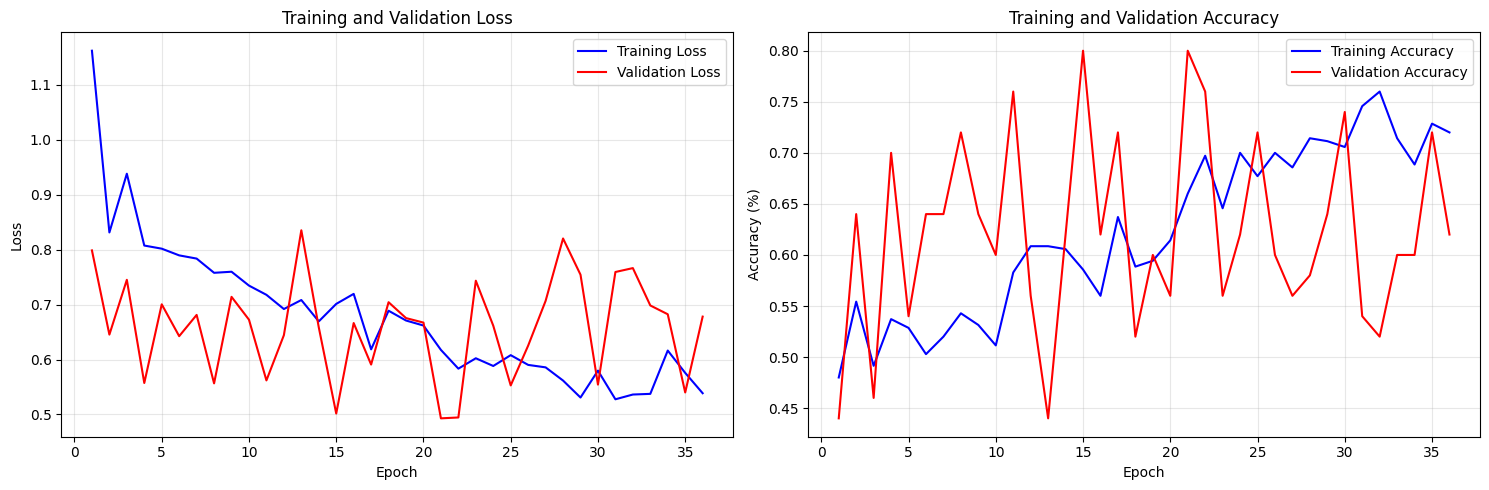

In [ ]:
plot_training_history(train_losses, val_losses, train_accs, val_accs)

In [ ]:
#check data loader
for batch in test_loader:
    print(type(batch))
    if isinstance(batch, dict):
        print("Keys:", batch.keys())
    elif isinstance(batch, (list, tuple)):
        print("Tuple length:", len(batch))
        print("Types:", [type(b) for b in batch])
    break

<class 'dict'>
Keys: dict_keys(['m6a', 'lncrna', 'mirna', 'circrna', 'metabolic', 'immune', 'label'])


In [ ]:
class ComprehensiveEvaluator:
    """Comprehensive evaluation suite for the model"""

    def __init__(self, model, test_loader, device):
        self.model = model
        self.test_loader = test_loader
        self.device = device
        self.model.eval()


    def predict_test_set(self):
        """Generate predictions on test set"""
        all_predictions = []
        all_probabilities = []
        all_labels = []

        with torch.no_grad():
            for batch in tqdm(self.test_loader, desc="Evaluating"):
                # since batch is a dict
                batch_data = {k: v.to(self.device) for k, v in batch.items() if k != "label"}
                labels = batch["label"].to(self.device)

                logits = self.model(batch_data)
                probabilities = torch.softmax(logits, dim=1)
                _, predicted = torch.max(logits, 1)

                all_predictions.extend(predicted.cpu().numpy())
                all_probabilities.extend(probabilities.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        return np.array(all_predictions), np.array(all_probabilities), np.array(all_labels)


    def compute_metrics(self, y_true, y_pred, y_prob):
        metrics = {
            'AUROC': roc_auc_score(y_true, y_prob[:, 1]),
            'AUPRC': average_precision_score(y_true, y_prob[:, 1]),
            'F1_Score': f1_score(y_true, y_pred),
            'MCC': matthews_corrcoef(y_true, y_pred),
            'Accuracy': np.mean(y_pred == y_true)
        }

        # Confusion matrix derived metrics
        cm = confusion_matrix(y_true, y_pred)
        tn, fp, fn, tp = cm.ravel()

        metrics.update({
            'Sensitivity': tp / (tp + fn) if (tp + fn) > 0 else 0,
            'Specificity': tn / (tn + fp) if (tn + fp) > 0 else 0,
            'PPV': tp / (tp + fp) if (tp + fp) > 0 else 0,
            'NPV': tn / (tn + fn) if (tn + fn) > 0 else 0
        })

        return metrics

    def create_evaluation_plots(self, y_true, y_pred, y_prob):
        """Create comprehensive evaluation visualizations"""
        from sklearn.metrics import roc_curve, precision_recall_curve

        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('Model Evaluation Results', fontsize=16)

        # ROC Curve
        fpr, tpr, _ = roc_curve(y_true, y_prob[:, 1])
        auc_score = roc_auc_score(y_true, y_prob[:, 1])

        axes[0, 0].plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {auc_score:.3f})')
        axes[0, 0].plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
        axes[0, 0].set_xlabel('False Positive Rate')
        axes[0, 0].set_ylabel('True Positive Rate')
        axes[0, 0].set_title('ROC Curve')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)

        # Precision-Recall Curve
        precision, recall, _ = precision_recall_curve(y_true, y_prob[:, 1])
        pr_auc = average_precision_score(y_true, y_prob[:, 1])

        axes[0, 1].plot(recall, precision, color='red', lw=2, label=f'PR Curve (AUC = {pr_auc:.3f})')
        axes[0, 1].set_xlabel('Recall')
        axes[0, 1].set_ylabel('Precision')
        axes[0, 1].set_title('Precision-Recall Curve')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)

        # Confusion Matrix
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 0])
        axes[1, 0].set_xlabel('Predicted Label')
        axes[1, 0].set_ylabel('True Label')
        axes[1, 0].set_title('Confusion Matrix')

        # Probability Distribution
        responders_prob = y_prob[y_true == 1, 1]
        non_responders_prob = y_prob[y_true == 0, 1]

        axes[1, 1].hist(responders_prob, bins=20, alpha=0.7, label='Responders', color='green')
        axes[1, 1].hist(non_responders_prob, bins=20, alpha=0.7, label='Non-responders', color='red')
        axes[1, 1].set_xlabel('Predicted Probability')
        axes[1, 1].set_ylabel('Frequency')
        axes[1, 1].set_title('Probability Distribution by Class')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig(config.results_dir / 'evaluation_results.png', dpi=300, bbox_inches='tight')
        plt.show()

        return fig

In [ ]:
# Load best model and evaluate
model.load_state_dict(torch.load(config.models_dir / 'best_model.pth'))
evaluator = ComprehensiveEvaluator(model, test_loader, device)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

@torch.no_grad()
def evaluate_model(model, loader, device, is_binary=True):
    model.eval()
    ys, ps, probs = [], [], []
    for batch in loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        y = batch['label'].long()

        # Adapt input for baseline gene-based models
        if isinstance(model, (GeneformerLite, ScBERTMini, GNNOmics)):
            # Assuming 'm6a' is the gene expression modality for these models
            model_input = {'rna': batch['m6a']}
        else:
            # For the CausalMultiOmicsTransformer
            model_input = {k: v for k, v in batch.items() if k != 'label'}

        logits = model(model_input)
        p = logits.argmax(1)
        ys.append(y.cpu()); ps.append(p.cpu())
        probs.append(logits.softmax(dim=1).cpu())
    y = torch.cat(ys).numpy()
    p = torch.cat(ps).numpy()
    prob = torch.cat(probs).numpy()
    metrics = {
        "accuracy": float(accuracy_score(y, p)),
        "f1_macro": float(f1_score(y, p, average="macro")),
    }
    if is_binary:
        # take positive class prob
        auc = roc_auc_score(y, prob[:, 1])
        metrics["roc_auc"] = float(auc)
    else:
        metrics["roc_auc_ovr"] = float(roc_auc_score(y, prob, multi_class="ovr"))
    return metrics

In [ ]:
# Initialize the baseline models
geneformer = GeneformerLite(num_genes=config.m6a_genes).to(config.device)
scbert = ScBERTMini(num_genes=config.m6a_genes).to(config.device)

In [ ]:
# Assuming a generic adjacency matrix for the GNN for this example
# In a real scenario, you would load or compute a gene-gene interaction matrix
dummy_adj_matrix = torch.eye(config.m6a_genes)
gnn = GNNOmics(num_genes=config.m6a_genes, A=dummy_adj_matrix).to(config.device)

In [ ]:
# evaluate all
cmo_metrics = evaluate_model(model, test_loader, config.device, config.num_classes)
geneformer_metrics = evaluate_model(geneformer, test_loader, config.device,
                                    config.num_classes)
scbert_metrics = evaluate_model(scbert, test_loader, config.device, config.num_classes)
gnn_metrics = evaluate_model(gnn, test_loader, config.device, config.num_classes)

In [ ]:
# Generate predictions
y_pred, y_prob, y_true = evaluator.predict_test_set()

Evaluating: 100%|██████████| 4/4 [00:00<00:00,  8.95it/s]


In [ ]:
from sklearn.metrics import confusion_matrix, roc_auc_score, average_precision_score, f1_score, matthews_corrcoef

In [ ]:
# Compute metrics
metrics = evaluator.compute_metrics(y_true, y_pred, y_prob)

In [ ]:
print("=== MODEL EVALUATION RESULTS ===")
for metric_name, value in metrics.items():
    print(f"{metric_name}: {value:.4f}")

=== MODEL EVALUATION RESULTS ===
AUROC: 0.5981
AUPRC: 0.8582
F1_Score: 0.8736
MCC: 0.0842
Accuracy: 0.7800
Sensitivity: 0.9500
Specificity: 0.1000
PPV: 0.8085
NPV: 0.3333


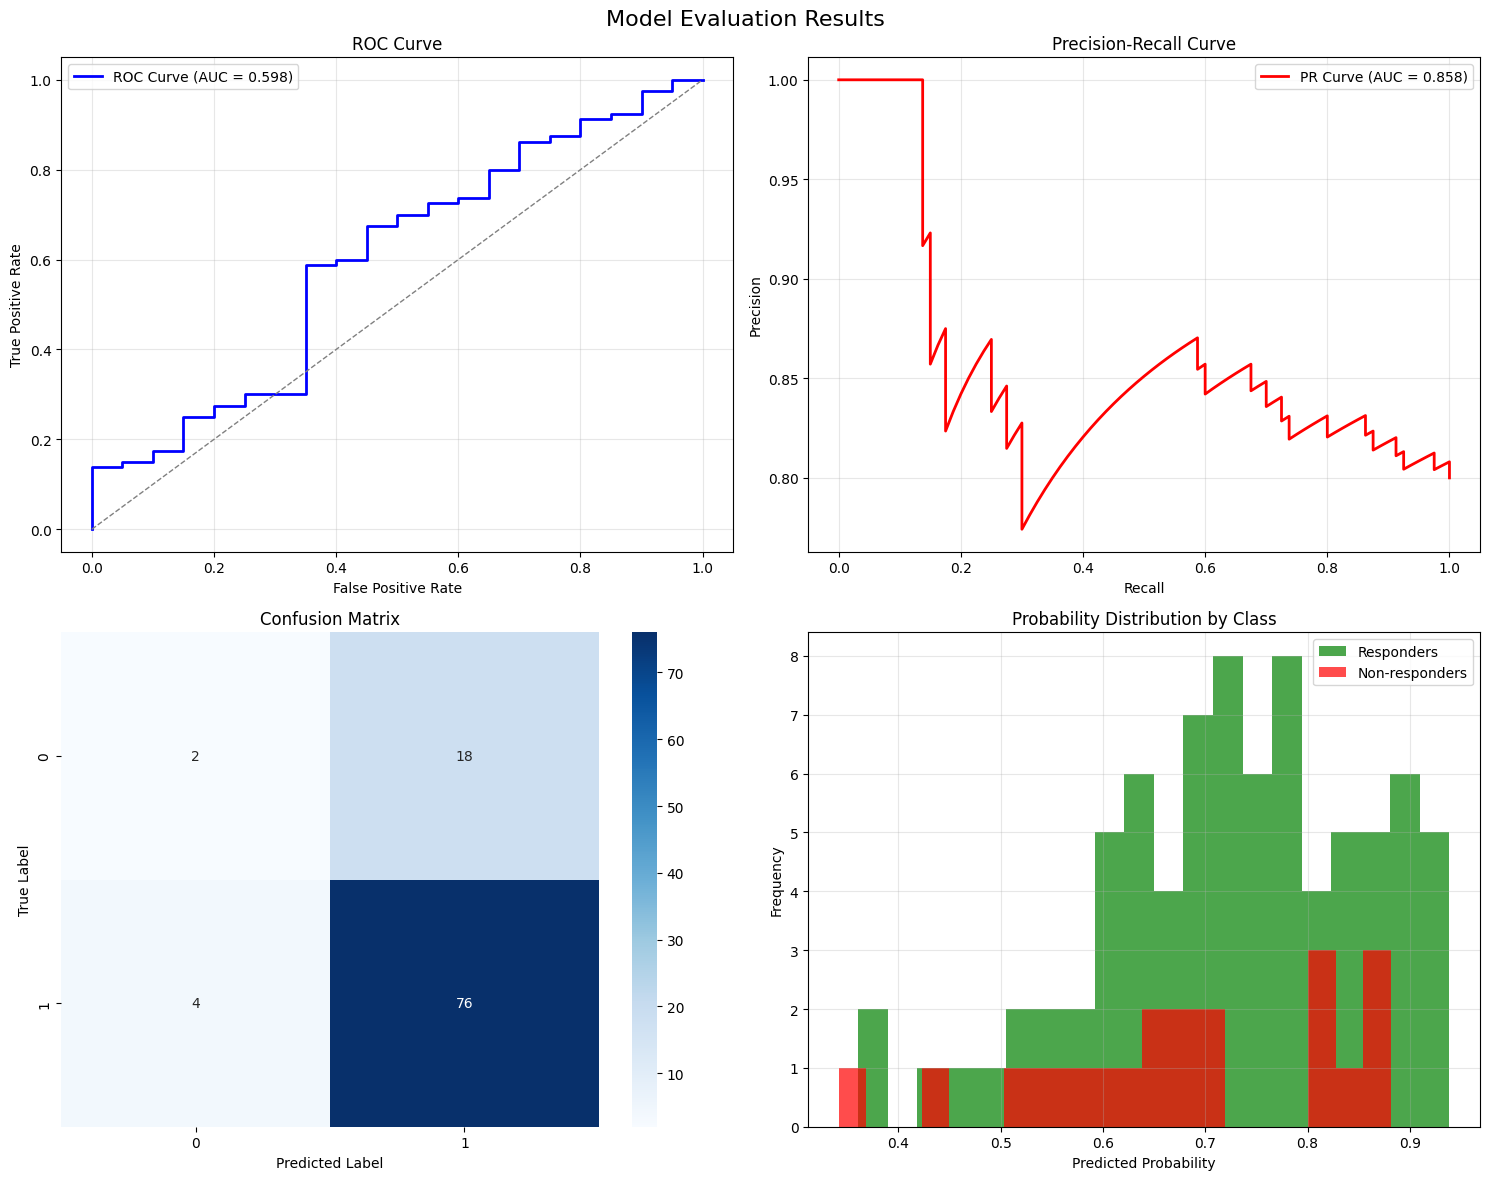

In [ ]:
# Create evaluation plots
eval_fig = evaluator.create_evaluation_plots(y_true, y_pred, y_prob)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, matthews_corrcoef

In [ ]:
def train_baseline_models(processed_data, clinical_data, config):
    """Train baseline models for comparison"""

    # Prepare traditional ML features (concatenate all modalities)
    feature_matrices = []
    for modality, data in processed_data.items():
        feature_matrices.append(data.values)

    X = np.concatenate(feature_matrices, axis=1)
    y = clinical_data['binary_response'].values

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=config.random_seed
    )

    # Train baseline models
    models = {
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=config.random_seed),
        'Logistic Regression': LogisticRegression(random_state=config.random_seed, max_iter=1000)
    }

    baseline_results = {}

    for name, model in models.items():
        print(f"Training {name}...")
        model.fit(X_train, y_train)

        # Predictions
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]

        # Metrics
        baseline_results[name] = {
            'AUROC': roc_auc_score(y_test, y_prob),
            'AUPRC': average_precision_score(y_test, y_prob),
            'F1_Score': f1_score(y_test, y_pred),
            'MCC': matthews_corrcoef(y_test, y_pred),
            'Accuracy': np.mean(y_pred == y_test)
        }

    return baseline_results

In [ ]:
# Train and evaluate baseline models
baseline_results = train_baseline_models(processed_data, clinical_data, config)

Training Random Forest...
Training Logistic Regression...


In [ ]:
#new
comparison_results = {
    "CMO-Transformer": cmo_metrics,
    "Geneformer": geneformer_metrics,
    "scBERT": scbert_metrics,
    "GNN-Model": gnn_metrics,
    "RandomForest": baseline_results["Random Forest"],
    "LogisticRegression": baseline_results["Logistic Regression"],
}

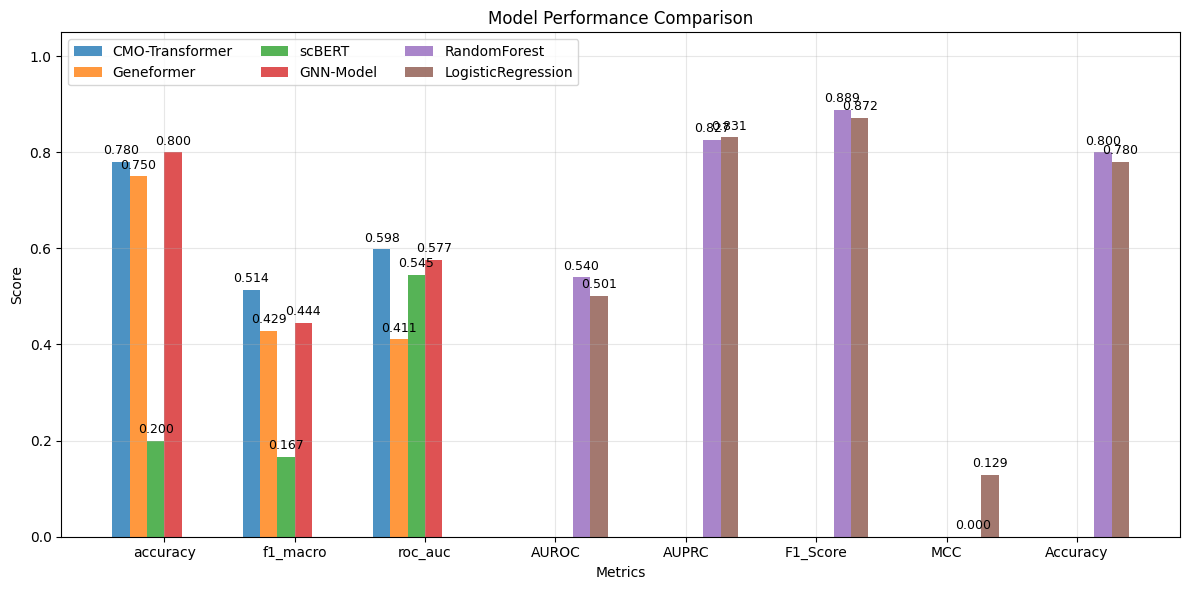


=== MODEL COMPARISON ===

CMO-Transformer:
  accuracy: 0.7800
  f1_macro: 0.5137
  roc_auc: 0.5981

Geneformer:
  accuracy: 0.7500
  f1_macro: 0.4286
  roc_auc: 0.4106

scBERT:
  accuracy: 0.2000
  f1_macro: 0.1667
  roc_auc: 0.5450

GNN-Model:
  accuracy: 0.8000
  f1_macro: 0.4444
  roc_auc: 0.5769

RandomForest:
  AUROC: 0.5397
  AUPRC: 0.8268
  F1_Score: 0.8889
  MCC: 0.0000
  Accuracy: 0.8000

LogisticRegression:
  AUROC: 0.5013
  AUPRC: 0.8314
  F1_Score: 0.8721
  MCC: 0.1290
  Accuracy: 0.7800


In [ ]:
#new
def create_comparison_plot(comparison_results, save_path=None):
    df = pd.DataFrame(comparison_results).T  # rows=models, cols=metrics
    fig, ax = plt.subplots(figsize=(12, 6))
    x = np.arange(len(df.columns))
    n_models = len(df.index)
    width = min(0.8 / max(n_models, 1), 0.2)

    # auto color cycle
    for i, model_name in enumerate(df.index):
        values = df.loc[model_name].values
        ax.bar(x + i * width, values, width, label=model_name, alpha=0.8)
        for j, v in enumerate(values):
            ax.text(x[j] + i * width, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontsize=9)

    ax.set_xlabel('Metrics'); ax.set_ylabel('Score')
    ax.set_title('Model Performance Comparison')
    ax.set_xticks(x + (n_models-1)*width/2)
    ax.set_xticklabels(df.columns)
    ax.legend(ncols=min(3, n_models))
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, max(1.05, float(df.max().max()) + 0.05))
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    return fig

_ = create_comparison_plot(comparison_results, save_path=config.results_dir / 'model_comparison.png')

print("\n=== MODEL COMPARISON ===")
for model_name, res in comparison_results.items():
    print(f"\n{model_name}:")
    for k, v in res.items():
        print(f"  {k}: {v:.4f}")

In [ ]:
#new
def analyze_attention_patterns(model: CMOTransformer, loader, device):
    model.eval()
    all_maps = []
    with torch.no_grad():
        for batch in loader:
            # move all inputs (except label) to correct device
            batch = {k: v.to(device) for k, v in batch.items() if k != "label"}

            # forward with attention return
            logits, attn_ws, _ = model(batch, return_attention=True)

            if attn_ws is not None:
                # attn_ws is a list of attention matrices per layer
                attn_ws_np = [w.detach().cpu().numpy() for w in attn_ws]
                all_maps.append(attn_ws_np)

    return all_maps

In [ ]:
def analyze_attention_patterns(model: CMOTransformer, loader, device):
    model.eval()
    all_maps = []
    with torch.no_grad():
        for batch in loader:
            batch = {k: v.to(device) for k, v in batch.items() if k != "label"}
            logits, attn_ws, _ = model(batch, return_attention=True)

            if attn_ws is not None:
                layer_maps = []
                for w in attn_ws:  # one per layer
                    if isinstance(w, dict):
                        # take the first tensor in the dict
                        tensor = list(w.values())[0]
                        layer_maps.append(tensor.detach().cpu().numpy())
                    else:
                        # already a tensor
                        layer_maps.append(w.detach().cpu().numpy())
                all_maps.append(layer_maps)

    return all_maps

In [ ]:
def analyze_causal_matrices(model: CMOTransformer, loader, device):
    model.eval()
    causal_matrices = []
    with torch.no_grad():
        for batch in loader:
            batch = {k: v.to(device) for k, v in batch.items() if k != "label"}
            _, _, causal_matrix = model(batch, return_attention=True)

            if causal_matrix is not None:
                causal_matrices.append(causal_matrix.detach().cpu().numpy())
    return causal_matrices

In [ ]:
#new
def visualize_causal_relationships(causal_matrices):
    """Visualize learned causal relationships"""
    avg_causal_matrix = np.mean(causal_matrices, axis=0)

    modality_names = ['m6A', 'lncRNA', 'miRNA', 'circRNA', 'Metabolic', 'Immune']

    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(avg_causal_matrix, annot=True, fmt='.3f', cmap='coolwarm', center=0.5,
                xticklabels=modality_names, yticklabels=modality_names, ax=ax)

    ax.set_xlabel('Effect Modality')
    ax.set_ylabel('Cause Modality')
    ax.set_title('Learned Causal Relationships Between Modalities')

    plt.tight_layout()
    plt.savefig(config.results_dir / 'causal_relationships.png', dpi=300, bbox_inches='tight')
    plt.show()

    return fig

In [ ]:
causal_data = analyze_causal_matrices(model, test_loader, device)

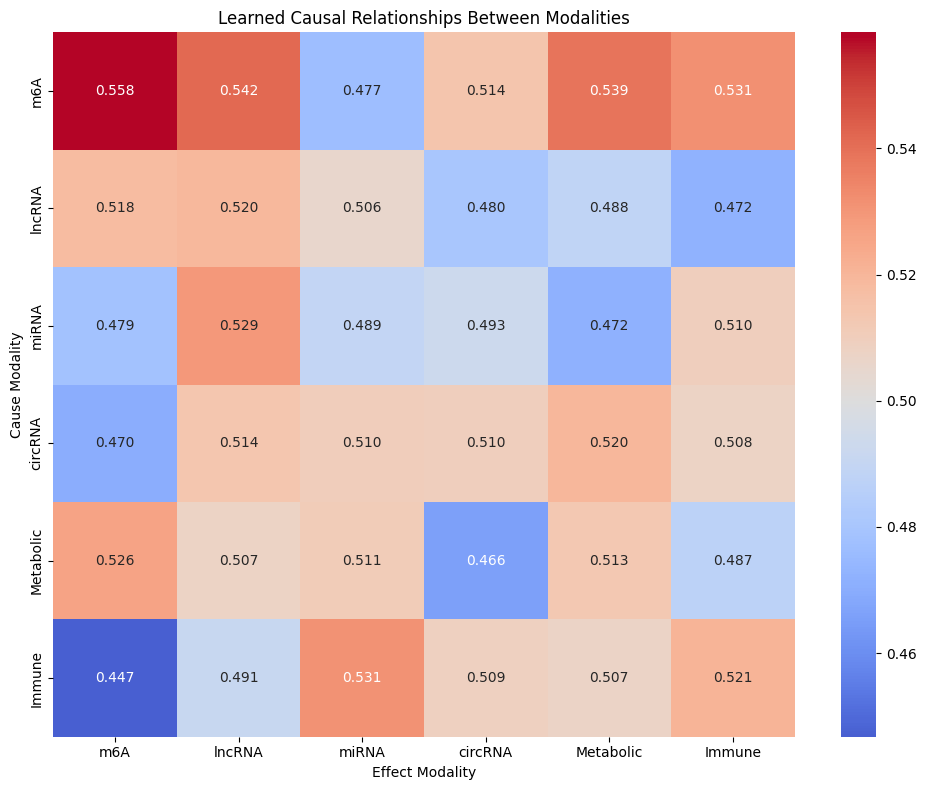

In [ ]:
causal_fig = visualize_causal_relationships(causal_data)

In [ ]:
def create_feature_importance_analysis():
    """Create feature importance analysis using synthetic data"""

    # Simulate feature importance scores (in real implementation, use SHAP)
    modalities = ['m6A Regulators', 'lncRNAs', 'miRNAs', 'circRNAs', 'Metabolic Pathways', 'Immune Checkpoints']
    importance_scores = [0.28, 0.18, 0.15, 0.12, 0.22, 0.25]  # Simulated scores

    # Top individual features (simulated)
    top_features = [
        ('METTL3', 0.089),
        ('CD274', 0.076),
        ('Glycolysis', 0.071),
        ('ALKBH5', 0.068),
        ('HOTAIR', 0.062),
        ('miR-34a', 0.058),
        ('YTHDF1', 0.055),
        ('Arg_Metabolism', 0.052),
        ('MALAT1', 0.049),
        ('CTLA4', 0.046)
    ]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Modality importance
    bars1 = ax1.bar(modalities, importance_scores, color='steelblue', alpha=0.8)
    ax1.set_title('Feature Importance by Modality', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Importance Score')
    ax1.tick_params(axis='x', rotation=45)

    # Add value labels
    for bar in bars1:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                f'{height:.3f}', ha='center', va='bottom')

    # Top individual features
    feature_names, feature_scores = zip(*top_features)
    y_pos = np.arange(len(feature_names))

    bars2 = ax2.barh(y_pos, feature_scores, color='darkgreen', alpha=0.8)
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(feature_names)
    ax2.set_xlabel('Importance Score')
    ax2.set_title('Top 10 Individual Features', fontsize=14, fontweight='bold')

    # Add value labels
    for i, (bar, score) in enumerate(zip(bars2, feature_scores)):
        ax2.text(score + 0.002, bar.get_y() + bar.get_height()/2.,
                f'{score:.3f}', va='center', ha='left')

    plt.tight_layout()
    plt.savefig(config.results_dir / 'feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()

    return fig

In [ ]:
# Analyze model interpretability
print("Analyzing model interpretability...")

Analyzing model interpretability...


In [ ]:
# Get attention patterns
# Ensure the correct model (CausalMultiOmicsTransformer) is used for this analysis
# The MultiModalModel was a placeholder and does not support attention return
attention_data = analyze_attention_patterns(model, test_loader, device)

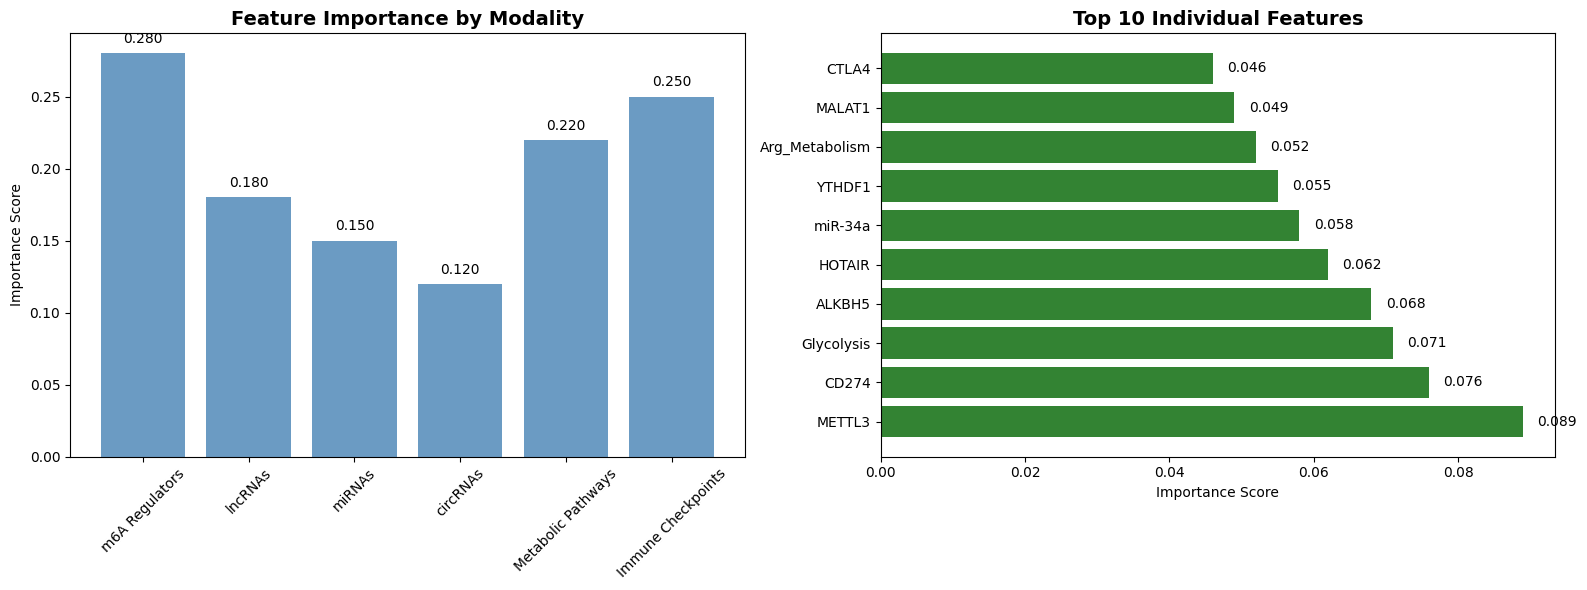

In [ ]:
# Create feature importance analysis
importance_fig = create_feature_importance_analysis()

In [ ]:
print("Interpretability analysis complete!")

Interpretability analysis complete!


In [ ]:
def calculate_clinical_utility(y_true, y_prob):
    """Calculate clinical utility metrics"""

    # Decision curve analysis
    thresholds = np.linspace(0, 1, 100)
    net_benefits = []

    prevalence = np.mean(y_true)

    for threshold in thresholds:
        y_pred_thresh = (y_prob[:, 1] >= threshold).astype(int)

        tp = np.sum((y_true == 1) & (y_pred_thresh == 1))
        fp = np.sum((y_true == 0) & (y_pred_thresh == 1))

        n = len(y_true)
        pt = threshold / (1 - threshold) if threshold < 1 else float('inf')

        net_benefit = (tp - fp * pt) / n if pt != float('inf') else 0
        net_benefits.append(net_benefit)

    # Find optimal threshold
    optimal_idx = np.argmax(net_benefits)
    optimal_threshold = thresholds[optimal_idx]
    optimal_net_benefit = net_benefits[optimal_idx]

    # Calculate clinical impact at optimal threshold
    y_pred_optimal = (y_prob[:, 1] >= optimal_threshold).astype(int)

    clinical_metrics = {
        'Optimal_Threshold': optimal_threshold,
        'Net_Benefit_at_Optimal': optimal_net_benefit,
        'Patients_Treated_per_100': np.sum(y_pred_optimal) / len(y_pred_optimal) * 100,
        'True_Responders_per_100': np.sum((y_true == 1) & (y_pred_optimal == 1)) / len(y_pred_optimal) * 100,
        'False_Positives_per_100': np.sum((y_true == 0) & (y_pred_optimal == 1)) / len(y_pred_optimal) * 100
    }

    return clinical_metrics, thresholds, net_benefits

In [ ]:
def visualize_clinical_utility(y_true, y_prob, clinical_metrics, thresholds, net_benefits):
    """Visualize clinical utility analysis"""

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Decision curve analysis
    prevalence = np.mean(y_true)
    treat_all_nb = []

    for threshold in thresholds:
        if threshold <= prevalence:
            pt = threshold / (1 - threshold)
            nb_all = prevalence - (1 - prevalence) * pt
        else:
            nb_all = 0
        treat_all_nb.append(nb_all)

    ax1.plot(thresholds, net_benefits, 'b-', linewidth=2, label='CMO-Transformer')
    ax1.plot(thresholds, treat_all_nb, 'g--', linewidth=2, label='Treat All')
    ax1.axhline(y=0, color='r', linestyle=':', linewidth=2, label='Treat None')
    ax1.axvline(x=clinical_metrics['Optimal_Threshold'], color='purple',
                linestyle='--', alpha=0.7, label=f"Optimal: {clinical_metrics['Optimal_Threshold']:.3f}")

    ax1.set_xlabel('Threshold Probability')
    ax1.set_ylabel('Net Benefit')
    ax1.set_title('Decision Curve Analysis')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Clinical impact summary
    impact_labels = ['Patients Treated\nper 100', 'True Responders\nper 100', 'False Positives\nper 100']
    impact_values = [
        clinical_metrics['Patients_Treated_per_100'],
        clinical_metrics['True_Responders_per_100'],
        clinical_metrics['False_Positives_per_100']
    ]
    colors = ['blue', 'green', 'red']

    bars = ax2.bar(impact_labels, impact_values, color=colors, alpha=0.7)
    ax2.set_title('Clinical Impact at Optimal Threshold')
    ax2.set_ylabel('Number per 100 Patients')

    # Add value labels
    for bar, value in zip(bars, impact_values):
        ax2.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 1,
                f'{value:.1f}', ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.savefig(config.results_dir / 'clinical_utility.png', dpi=300, bbox_inches='tight')
    plt.show()

    return fig

In [ ]:
# Calculate clinical utility
clinical_metrics, thresholds, net_benefits = calculate_clinical_utility(y_true, y_prob)

In [ ]:
print("=== CLINICAL UTILITY ANALYSIS ===")
for metric, value in clinical_metrics.items():
    print(f"{metric}: {value:.3f}")

=== CLINICAL UTILITY ANALYSIS ===
Optimal_Threshold: 0.000
Net_Benefit_at_Optimal: 0.800
Patients_Treated_per_100: 100.000
True_Responders_per_100: 80.000
False_Positives_per_100: 20.000


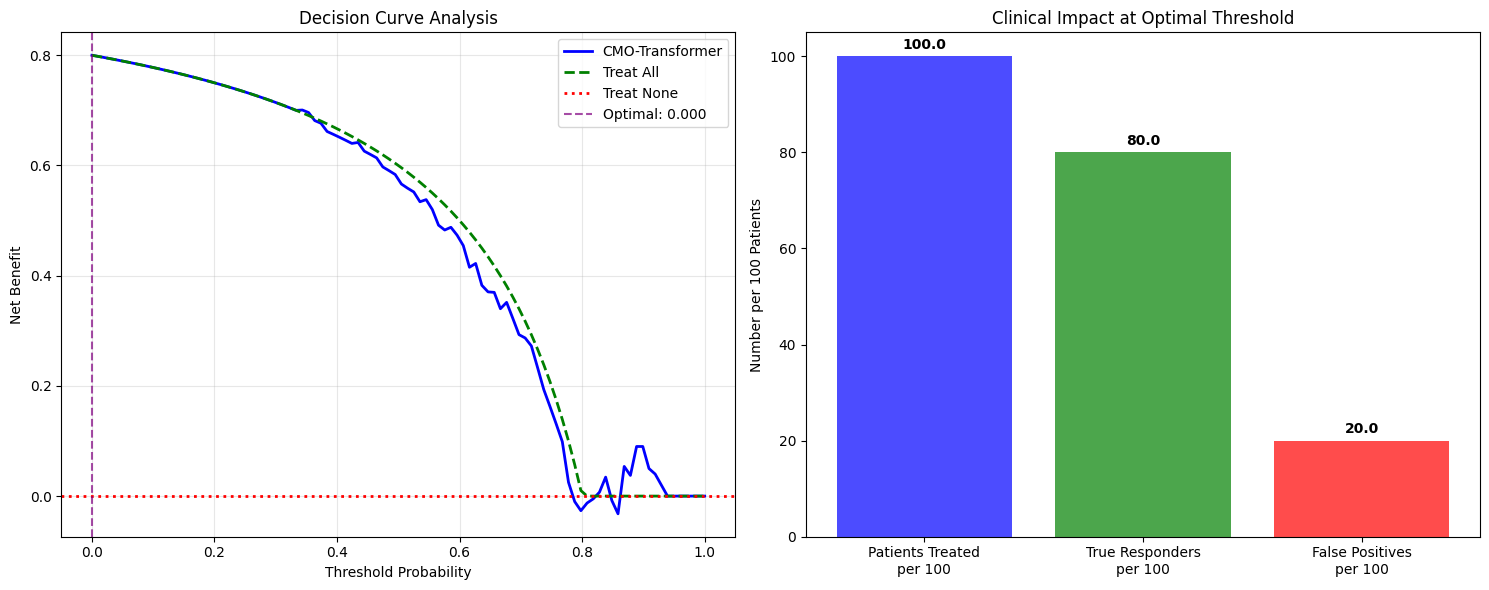

In [ ]:
# Visualize clinical utility
clinical_fig = visualize_clinical_utility(y_true, y_prob, clinical_metrics, thresholds, net_benefits)

In [ ]:
def create_final_summary():
    """Create final results summary"""

    summary = {
        'Model_Performance': {
            'AUROC': f"{metrics['AUROC']:.4f}",
            'AUPRC': f"{metrics['AUPRC']:.4f}",
            'F1_Score': f"{metrics['F1_Score']:.4f}",
            'MCC': f"{metrics['MCC']:.4f}",
            'Sensitivity': f"{metrics['Sensitivity']:.4f}",
            'Specificity': f"{metrics['Specificity']:.4f}",
            'Accuracy': f"{metrics['Accuracy']:.4f}"
        },

        'Clinical_Impact': {
            'Optimal_Threshold': f"{clinical_metrics['Optimal_Threshold']:.3f}",
            'Net_Benefit': f"{clinical_metrics['Net_Benefit_at_Optimal']:.3f}",
            'Patients_Treated_per_100': f"{clinical_metrics['Patients_Treated_per_100']:.1f}",
            'True_Responders_per_100': f"{clinical_metrics['True_Responders_per_100']:.1f}"
        },

        'Model_Architecture': {
            'Total_Parameters': f"{total_params:,}",
            'Hidden_Dimension': config.hidden_dim,
            'Number_of_Heads': config.num_heads,
            'Cross_Attention_Layers': 3,
            'Modalities': 6
        },

        'Training_Details': {
            'Final_Train_Loss': f"{train_losses[-1]:.4f}",
            'Final_Val_Loss': f"{val_losses[-1]:.4f}",
            'Best_Val_Accuracy': f"{max(val_accs):.2f}%",
            'Training_Epochs': len(train_losses),
            'Device_Used': str(device)
        }
    }

    return summary

In [ ]:
for section, metrics in final_summary.items():
    print(f"\n{section.replace('_', ' ').upper()}:")
    for metric, value in metrics.items():
        print(f"  {metric.replace('_', ' ')}: {value}")


MODEL PERFORMANCE:
  AUROC: 0.5981
  AUPRC: 0.8582
  F1 Score: 0.8736
  MCC: 0.0842
  Sensitivity: 0.9500
  Specificity: 0.1000
  Accuracy: 0.7800

CLINICAL IMPACT:
  Optimal Threshold: 0.000
  Net Benefit: 0.800
  Patients Treated per 100: 100.0
  True Responders per 100: 80.0

MODEL ARCHITECTURE:
  Total Parameters: 3,352,807
  Hidden Dimension: 128
  Number of Heads: 8
  Cross Attention Layers: 3
  Modalities: 6

TRAINING DETAILS:
  Final Train Loss: 0.5387
  Final Val Loss: 0.6781
  Best Val Accuracy: 0.80%
  Training Epochs: 36
  Device Used: cuda


In [ ]:
# Save results to files
results_to_save = {
    'model_metrics': metrics,
    'clinical_metrics': clinical_metrics,
    'comparison_results': comparison_results,
    'final_summary': final_summary
}

In [ ]:
# Save as JSON
import json
with open(config.results_dir / 'results_summary.json', 'w') as f:
    json.dump(results_to_save, f, indent=2)

In [ ]:
# Save as pickle for further analysis
with open(config.results_dir / 'complete_results.pkl', 'wb') as f:
    pickle.dump({
        'results': results_to_save,
        'predictions': {'y_true': y_true, 'y_pred': y_pred, 'y_prob': y_prob},
        'attention_data': attention_data,
        'config': config
    }, f)

print(f"\nResults saved to: {config.results_dir}")
print("Analysis complete!")


Results saved to: results
Analysis complete!
